# Analyzing and predicting house pricing

## Introduction

Suppouse you are working at a real estate agent, how can you find the best price your client can sell their house?
Given the attributes of a house, how can we do analyze and estimate its values? This tutorial will introduce you to some basic methods for analysing the house price of Boston, then using regression method to predict the house price. We are going to use several statistical analysis tools to build the best model to predict the value of a given house. 

### Tutorial content
In this tutorial, we will show how to do some basic statical analysis in Python.
The dataset is available either for download from the UCI ML repository ( http://archive.ics.uci.edu/ml/datasets/Housingor) or via a Python library scikit-learn. 

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading and preprocessing data](#loading_data)
- [Data Exploration](#data_exploration)
- [Regression Model](#regression_model)
- [Grid Search](#grid_serch)
- [Prediction](#prediction)


We'll utilize some useful packages:
* numpy - efficient numerical computations
* pandas - data structures for data analysis
* scikit-learn - machine learning algorithms, dataset access
* matplotlib - plotting (both interactive and to files)
* seaborn - extra plot types, elegant and readable plot style

plotting the house price of Beijing from 1992 to 2015

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use:

In [28]:
import pandas as pd;
from pandas import DataFrame,Series
import numpy as np
import matplotlib
%matplotlib inline
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeRegressor

## Loading and preprocessing data <a id='loading_data'></a>

We will load dataset into a pandas DataFrame.
The dataset consists of a table - columns are attributes, rows are instances (individual observations). 
The attributes include:

1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per \$10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    lower status of the population
14. MEDV     Median value of owner-occupied homes in \$1000's

As scikit-learn already provides a function to load this data set, we can simlpy load it by:

In [18]:
from sklearn.datasets import load_boston
def load_data():
    dataset = load_boston()
    df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    df['target'] = dataset.target
    return df

# test
df = load_data()

We can see the data pytes of each columns, and checking the nanvalue, fortunately, there is no missing values in this dataset

In [19]:
print df.head()
print '\ndata types information: '
print df.dtypes
print '\nmissing values information: '
print df.isnull().sum().sum()
print df.columns
print df.target[:10]

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  target  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  

data types information: 
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
target     float64
dtype: object

missing values information: 
0
Index([

we then randomly split the data into training set (70%) and testing set(30%) with a helper function `train_test_split` in  scikit-learn :

In [20]:
from sklearn.cross_validation import train_test_split
def split_data(df):
    X, y = df.drop(['target'],axis=1), df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, random_state=42)
    return X_train, y_train, X_test, y_test

In [21]:
X_train, y_train, X_test, y_test = split_data(df)
print X_train.head()
print '\n'
print y_train.head()

         CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD    TAX  \
5     0.02985  0.0   2.18   0.0  0.458  6.430  58.7  6.0622   3.0  222.0   
116   0.13158  0.0  10.01   0.0  0.547  6.176  72.5  2.7301   6.0  432.0   
45    0.17142  0.0   6.91   0.0  0.448  5.682  33.8  5.1004   3.0  233.0   
16    1.05393  0.0   8.14   0.0  0.538  5.935  29.3  4.4986   4.0  307.0   
468  15.57570  0.0  18.10   0.0  0.580  5.926  71.0  2.9084  24.0  666.0   

     PTRATIO       B  LSTAT  
5       18.7  394.12   5.21  
116     17.8  393.30  12.04  
45      17.9  396.90  10.21  
16      21.0  386.85   6.58  
468     20.2  368.74  18.13  


5      28.7
116    21.2
45     19.3
16     23.1
468    19.1
Name: target, dtype: float64


then we split the data into training set and testing set

## Data Exploration <a id='data_exploration'></a>

### Statistical analyze of the target value

In [22]:
def data_exploration(df):
    housing_prices = df['target']
    number_of_houses = df.shape[0]
    number_of_features = df.shape[1]
    max_price = np.max(housing_prices)
    min_price = np.min(housing_prices)
    mean_price = np.mean(housing_prices) 
    median_price = np.median(housing_prices)
    standard_deviation = np.std(housing_prices)

    print "number of houses:",number_of_houses
    print "number of features:",number_of_features
    print "max price of house:",max_price
    print "min price of house:",min_price
    print "mean price of house:",mean_price
    print "median price of house:",median_price
    print "standard deviation for prices of house:",standard_deviation

#data_exploration(df)

### Corelations between attributes

A good feature subset is one that contains features highly correlated with (predictive of) the class, yet uncorrelated with (not predictive of) each other. As the number of attributes in this data set is 13, Correlated features might make some trouble, therefore, it is wise for us to know whether some pairs of attributes are correlated and how much. 
There exist some methods such as PCA for deriving features that are as uncorrelated as possible.

We use `Pandas` correlation coefficients via the `DataFrame.corr()` function, and we choose the standard Pearson mehtod. The values of correlation range from -1 to 1, where 1 means total correlation, -1 means negative correlation, 0 means no correlation. 

In [26]:
corr = df.corr(method='pearson')

In particular, we use the standard matplotlib package and additionally seaborn for some extra statistical plots and for more elegant and comprehensible plot styles.

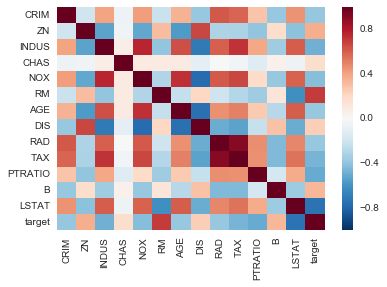

In [29]:
with sns.axes_style("white"):
    corr_fig = seaborn.heatmap(corr, vmin=-1, vmax=1)

### Predictivity

we then find out the corelations between each attribute and the predicted targets

In [30]:
pearson = df.corr(method='pearson')
# assume target attr is the last, then remove corr with itself
corr_with_target = pearson.ix[-1][:-1]
print corr_with_target

CRIM      -0.385832
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
Name: target, dtype: float64


In order to find out the attributes with strong correlations (positive or negative) to the target value, it would be better to sort the correlations by the absolute value:

In [31]:
print '\n'
print corr_with_target[abs(corr_with_target).argsort()[::-1]]



LSTAT     -0.737663
RM         0.695360
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.385832
RAD       -0.381626
AGE       -0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: target, dtype: float64


the top 5 factor is:
1. LSTAT (lower status of the population)
2. RM average number of rooms per dwelling
3. PTRATIO pupil-teacher ratio by town
4. INDUS proportion of non-retail business acres per town
5. TAX full-value property-tax rate per $10,000

## Regression Model <a id='regression_model'></a> 

DecisionTree is a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Therefore, we use the objective of this section is to investigate the relationship between the resale prices of
Singapore public housing of all types and housing attributes and identify the significant determinants of the resale prices based on the built housing price tree.

### performance metric 
We use the Mean Squared Error (MSE) as a performance metric

In [32]:
from sklearn.metrics import mean_squared_error 
def performance_metric(label, prediction):
    """Calculate and return the appropriate error performance metric."""
    return mean_squared_error(label,prediction)

### Learning curve

We want to khow better does the model get at predicting the target as you the increase number of instances used to train it. Learning curve refers to a plot of the prediction accuracy/error vs. the training set size. 
In the following part, we vary the size of training set by 50 different values.

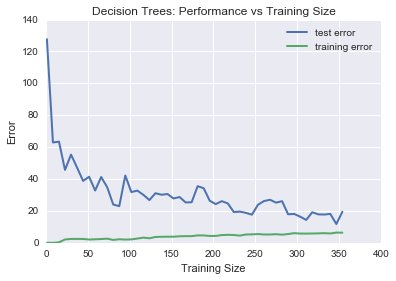

In [33]:
def learning_curve(depth, X_train, y_train, X_test, y_test, n):
    '''Calculate the performance of the model after a set of training data.
    we vary the size of training set by n differnet values.
    '''
    sizes = np.linspace(1, len(X_train), n)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))
    for i, p in enumerate(sizes):
        s = (int)(p)
        regressor = DecisionTreeRegressor(max_depth=depth)
        regressor.fit(X_train[:s], y_train[:s])
        # Find the performance on the training and testing set
        train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))
    
    plot_learning_curve(sizes, train_err, test_err)

    

def plot_learning_curve(sizes, train_err, test_err):
    '''Plot training and test error as a function of the training size.'''
    pl.figure()
    pl.title('Decision Trees: Performance vs Training Size')
    pl.plot(sizes, test_err, lw=2, label = 'test error')
    pl.plot(sizes, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Training Size')
    pl.ylabel('Error')
    pl.show() 

#test
depth = 5
n = 50
learning_curve(depth, X_train, y_train, X_test, y_test, n)

We can see that as the training size increase, the test error is decreasing overall however with fluctuation.

### Model Complexity

The maximum depth of tree is related to the model complexity. In this part, we calculate the performance of the model as model complexity increases.

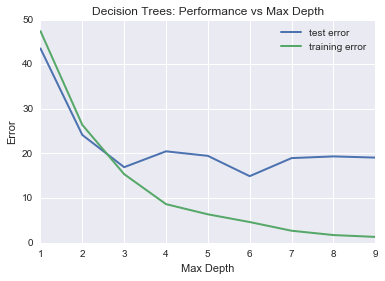

In [34]:
def model_complexity(X_train, y_train, X_test, y_test, k):
    '''Calculate the performance of the model as model complexity increases.
    vary the depth of decision trees from 2 to k
    '''

    max_depth = np.arange(1, k)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        regressor = DecisionTreeRegressor(max_depth=d)
        regressor.fit(X_train, y_train)
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity
    plot_model_complexity(max_depth, train_err, test_err)


def plot_model_complexity(max_depth, train_err, test_err):
    '''Plot training and test error as a function of the depth of the decision tree learn.'''

    pl.figure()
    pl.title('Decision Trees: Performance vs Max Depth')
    pl.plot(max_depth, test_err, lw=2, label = 'test error')
    pl.plot(max_depth, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Max Depth')
    pl.ylabel('Error')
    pl.show()

#test
model_complexity(X_train, y_train, X_test, y_test, 10)

As we can see, as the maximum tree depth increase, the test error is firstly decreased then getting more stable when the maximum tree depth reaches 3.

## Grid Search <a id='grid_search'></a>

In machine learning, hyperparameter optimization or model selection is the problem of choosing a set of hyperparameters for a learning algorithm. As these hyperparameter won't be learned by the model, they must be tuned for improving prediction performance. 

Except for trying different combination of value sets, we can perform a simply an exhaustive searching strategy called `Grid Search` to perform hyperparameter optimization.

A grid search algorithm must be:
* guided by some performance metric
* typically measured by cross-validation on the training set or evaluation on a held-out validation set

In order to wrap scoring functions for use in GridSearchCV and cross_val_score the grid search process, we use sklearn's metrics.make_scorer, which takes a score function, such as accuracy_score, mean_squared_error, adjusted_rand_index or average_precision and returns a callable that scores an estimator’s output.

In [35]:
from sklearn import cross_validation, metrics, grid_search

def grid_serach(df):
    '''Find and tune the optimal model. Make a prediction on housing data.
    return the tuned regression model'''

    X, y = df.drop(['target'],axis=1), df['target']
    regressor = DecisionTreeRegressor()

    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    scorer = metrics.make_scorer(performance_metric, greater_is_better=False)
    reg = grid_search.GridSearchCV(regressor, parameters, scoring=scorer, verbose=True)

    print "Final Model: "
    print reg.fit(X, y)
    print "Best Parameters: ", reg.best_params_
    return reg

#test
df = load_data()
reg = grid_serach(df)

Final Model: 
Fitting 3 folds for each of 10 candidates, totalling 30 fits
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(performance_metric, greater_is_better=False),
       verbose=True)
Best Parameters:  {'max_depth': 8}


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


Using the 

Once trained, we can export the tree in Graphviz format using the export_graphviz exporter.

In [ ]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(reg, out_file=f)

## Prediction <a id='prediction'></a>

After training the regression decision tree model, given a new data, we can use the pre-trained model to predict to hourse price.

In [ ]:
def predict(reg, x):
    '''Use the pre tuned model to predict the output of a particular sample'''
    y = reg.predict(x)
    print "House: " + str(x)
    print "Prediction: " + str(y)
    
# test 
x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
predict(reg,x)

## Put all codes together to building a decision tree

number of houses: 506
number of features: 14
max price of house: 50.0
min price of house: 5.0
mean price of house: 22.5328063241
median price of house: 21.2
standard deviation for prices of house: 9.18801154528
max depth:
1


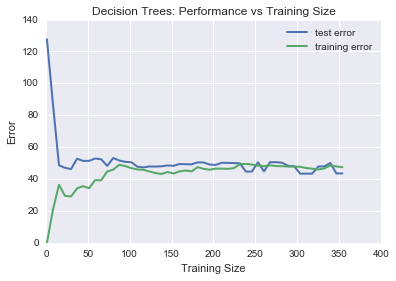

max depth:
2


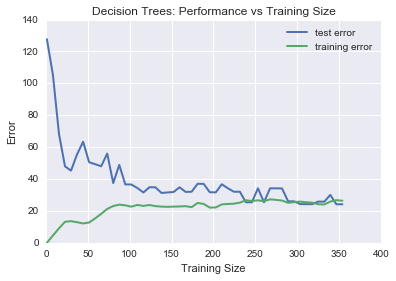

max depth:
3


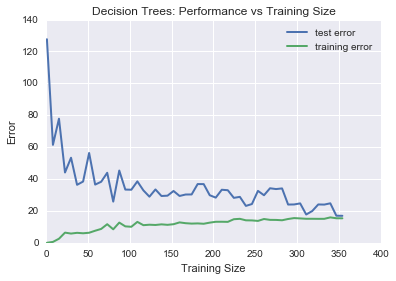

max depth:
4


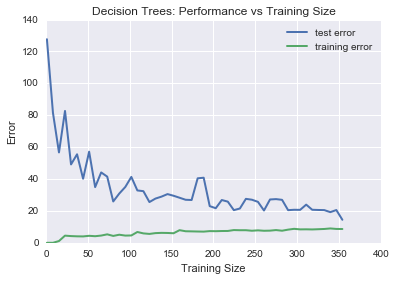

max depth:
5


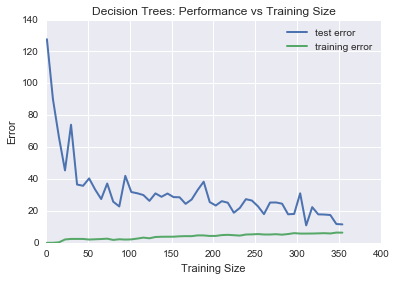

max depth:
6


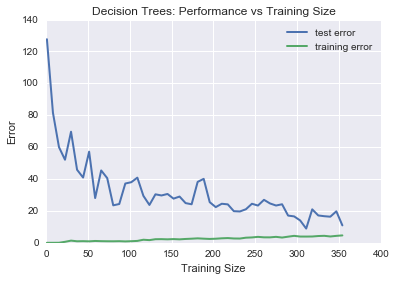

max depth:
7


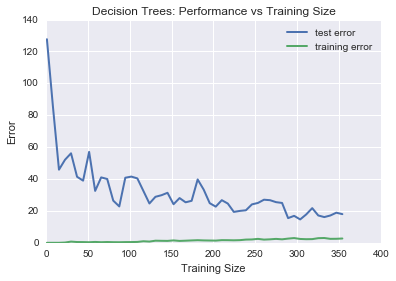

max depth:
8


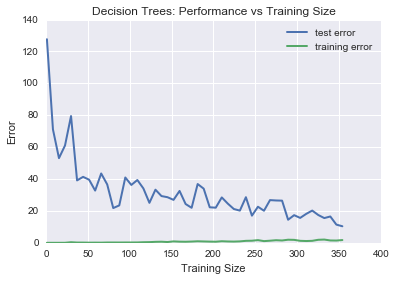

max depth:
9


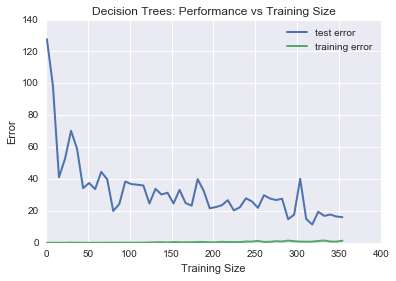

max depth:
10


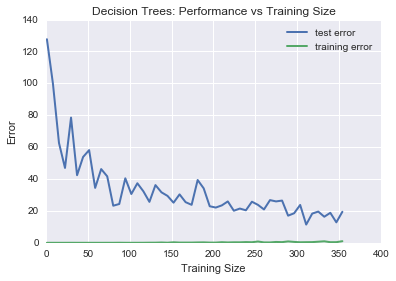

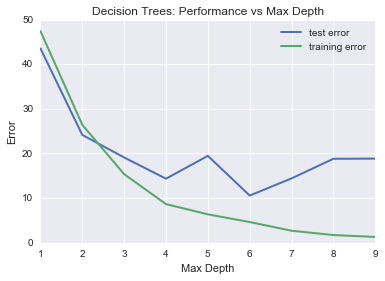

Final Model: 
Fitting 3 folds for each of 10 candidates, totalling 30 fits
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(performance_metric, greater_is_better=False),
       verbose=True)
Best Parameters:  {'max_depth': 7}


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [44]:
df = load_data()
data_exploration(df)
X_train, y_train, X_test, y_test = split_data(df)
max_depths = range(1,11)
n = 50  # parameter to set the training data size
k = 10  # model complexity
for max_depth in max_depths:
    print 'max depth:'
    print max_depth
    learning_curve(max_depth, X_train, y_train, X_test, y_test, n)

# Model Complexity Graph
model_complexity(X_train, y_train, X_test, y_test, k)

# Grid search
reg = grid_serach(df)

## Decision Tree Regression with AdaBoost  <a id='adaboost'></a>

Although decision tree is convenient for us to predict the house price, however, it is not stable: a small change/fluctuation in the data  can make a large difference! Therefore, boosting methods are combined with many decision trees to fix this problem. In the following section, we will show how Adaboost decision trees work, and do an experiment to find out whether Adaboost is useful or not.

It is very convient for us to use AdaboostRegressor in scikit-learn, and we just need to use DecisionTreeRegressor as its estimaor.

In [71]:
from sklearn.ensemble import AdaBoostRegressor
rng = np.random.RandomState(1)
reg_adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),n_estimators=10, random_state=rng)
reg_adaboost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=10,
         random_state=<mtrand.RandomState object at 0x11769c4b0>)

now we can compare the performance of pure decision tree method and the adaboosted decision tree method

In [ ]:
MaxDepth=8

reg_decision_tree = DecisionTreeRegressor(max_depth=MaxDepth)
reg_decision_tree.fit(X_train, y_train)

rng = np.random.RandomState(1)
reg_adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=MaxDepth),n_estimators=10, random_state=rng)
reg_adaboost.fit(X_train, y_train)

# Predict
predict_y_test_1 = reg_decision_tree.predict(X_test)
predict_y_test_2 = reg_adaboost.predict(X_test)

error_DT = mean_squared_error(y_test, predict_y_test_1)
error_adaboost_DT = mean_squared_error(y_test, predict_y_test_2)
print "max depth: ",MaxDepth
print "error when only using decision tree: " , error_DT
print "error when using decition tree with adaboost: " , error_adaboost_DT

As we can see, using Adaboost Decision Trees can improve the performance of prediction. 